IMPORTING NECCESSARY MODULES

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
#reading the csv data into a dataframe
df = pd.read_csv("Documents/auth/Bank Customer Churn Prediction.csv")
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


DATA EXPLORATION

In [5]:
#checking the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [6]:
#checking for null values
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

No null values

In [7]:
#checking for high or low cardinality amongst categorical data
df.select_dtypes("object").nunique()

country    3
gender     2
dtype: int64

Both country and gender columns has low cardinality but they are valuable predictors, so mot dropping them.

In [8]:
#checking for multicolinearity amidst the numeric columns
corr = df.drop(columns='churn').select_dtypes("number").corr()
corr

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,1.000000,0.005308,0.009497,-0.014883,-0.012419,0.016972,-0.014025,0.001665,0.015271
credit_score,0.005308,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384
age,0.009497,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201
tenure,-0.014883,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784
balance,-0.012419,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797
products_number,0.016972,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204
credit_card,-0.014025,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933
active_member,0.001665,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421
estimated_salary,0.015271,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000


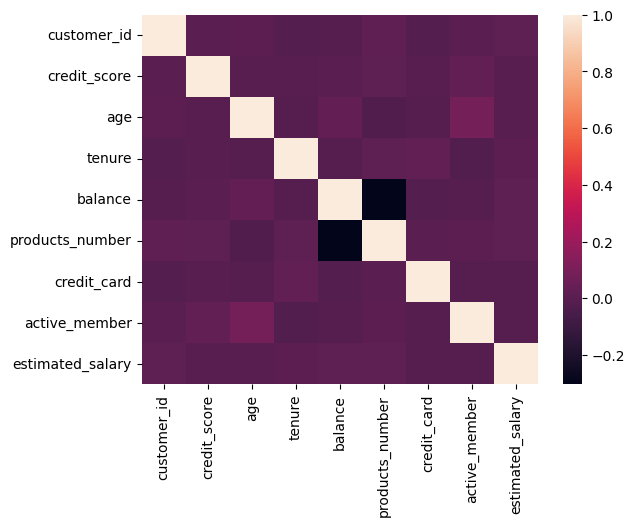

In [9]:
#use seaborn heatmap to visualise
sns.heatmap(corr);

No high correlation between the numeric columns

In [11]:
#checking for numeric columns with low variance 
low_variance_features = [col for col in df.drop(columns='churn').select_dtypes("number") if df[col].var() < 0.01]
low_variance_features

[]

There is no numeric columns with low variance

The customer_id column is irrelevant for our model.

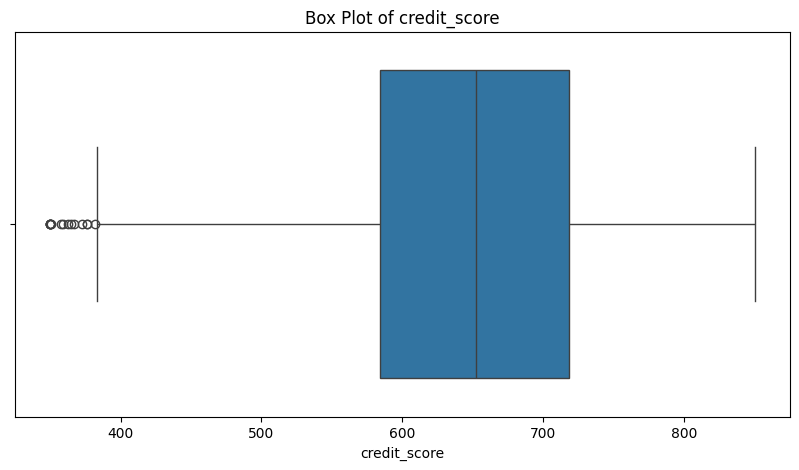

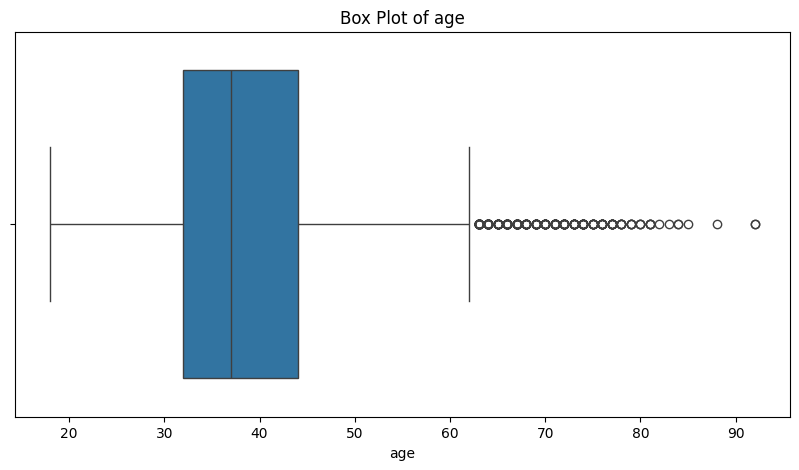

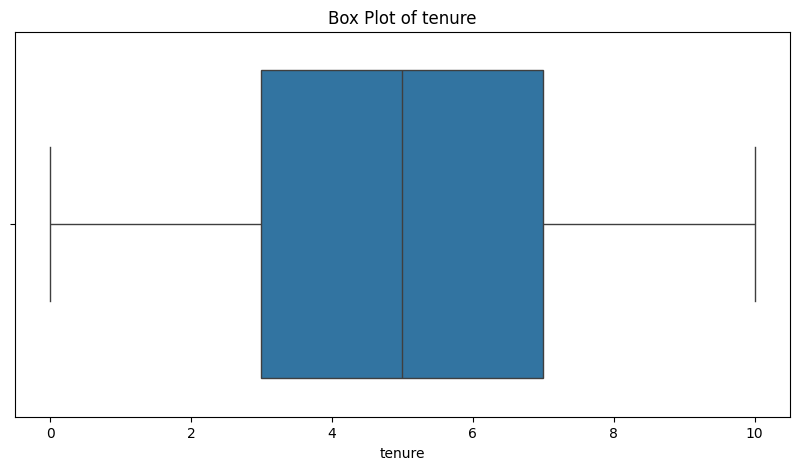

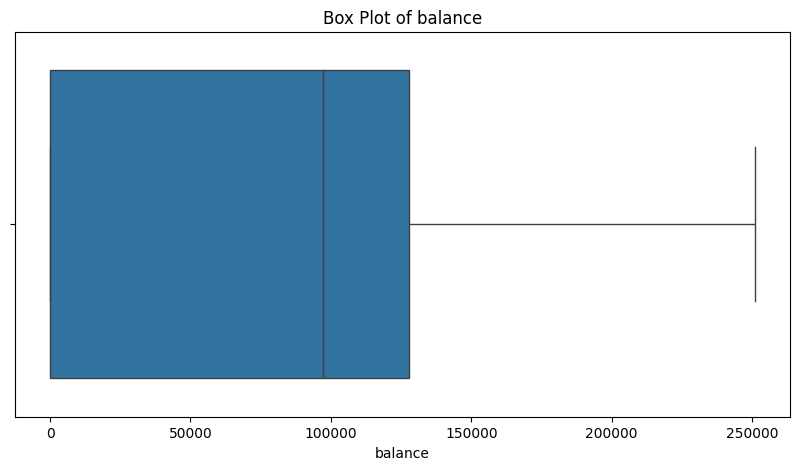

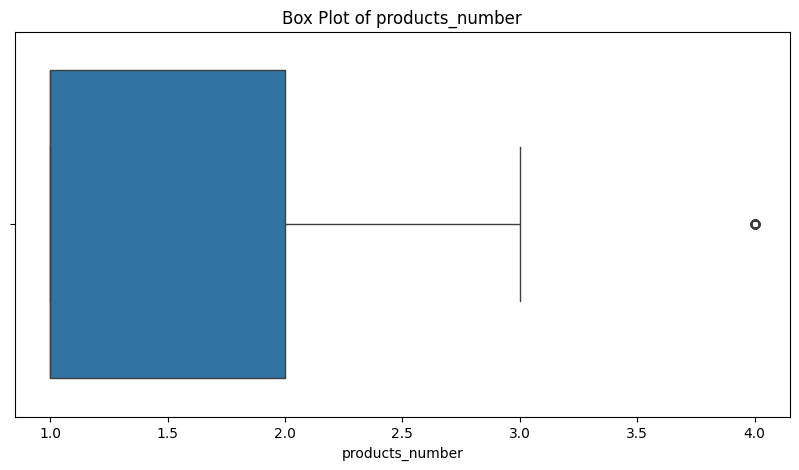

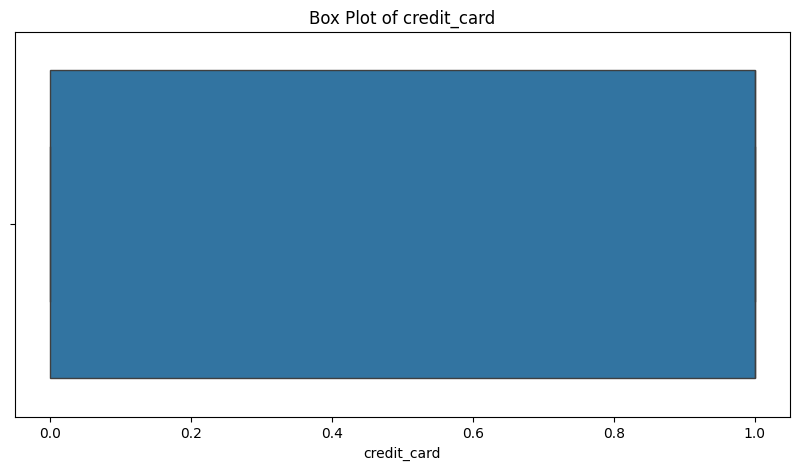

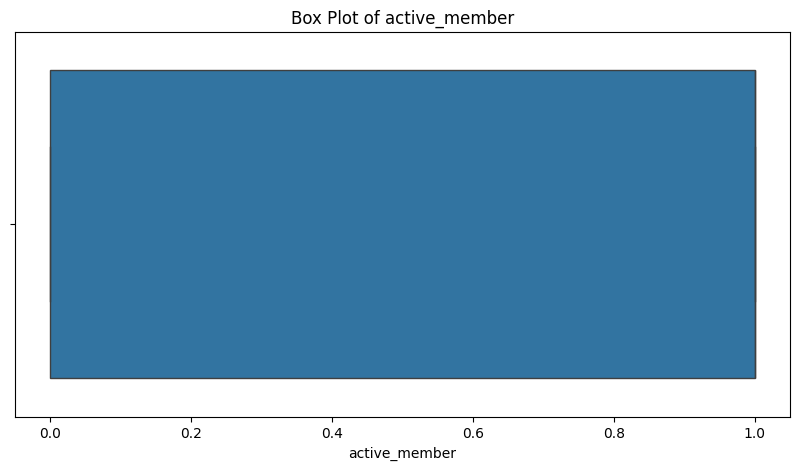

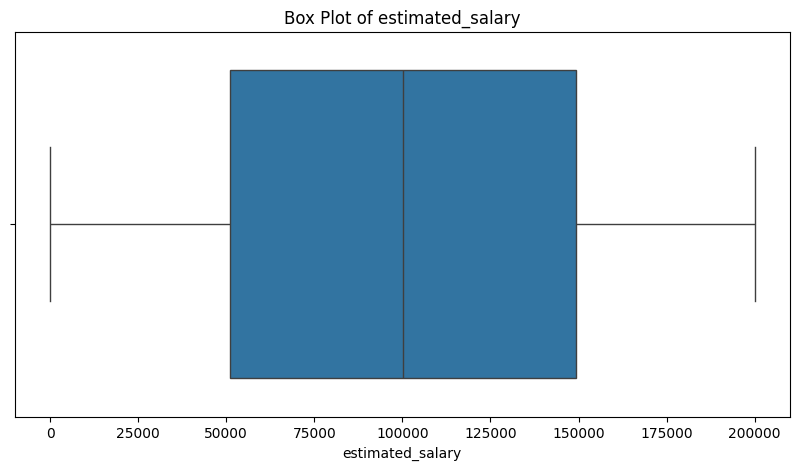

In [17]:
#checking for outliers
for column in df.drop(columns='churn').select_dtypes("number"):
    plt.figure(figsize=(10,5))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

credit_score, age and products_number have outliners.

Lets investigate these three columns to see if the outliners are valid data points

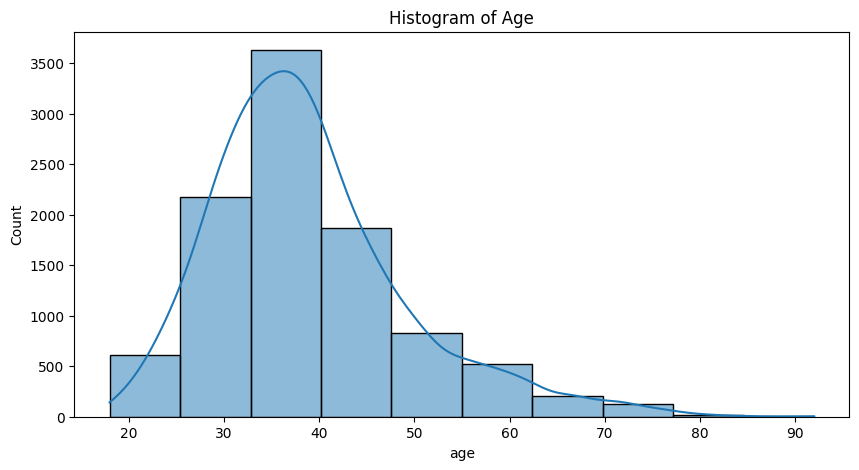

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(df['age'], bins=10, kde=True)
plt.title('Histogram of Age');

In [22]:
df['age'].value_counts().sort_values()

age
83      1
82      1
85      1
88      1
92      2
     ... 
34    447
36    456
35    474
38    477
37    478
Name: count, Length: 70, dtype: int64

In [23]:
df['products_number'].value_counts().sort_values()

products_number
4      60
3     266
2    4590
1    5084
Name: count, dtype: int64

In [24]:
df['credit_score'].value_counts().sort_values()

credit_score
419      1
395      1
373      1
382      1
412      1
      ... 
667     53
705     53
655     54
678     63
850    233
Name: count, Length: 460, dtype: int64

Conclusion:

- age and products_number are valid points, so no need to do a data trnsformation
- credit_score will be transformed using the standard scaler

In [12]:
#dropping the customer_id column due to its irrelevancy
df.drop('customer_id', axis=1, inplace=True)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


DATA TRANSFORMATION

In [15]:
#encoding the categorical features(gender, country)
df = pd.get_dummies(df, columns=['gender', 'country'], drop_first=True)
df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,gender_Male,country_Germany,country_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True


In [31]:
#initializing the standard scaler
scaler = StandardScaler()

In [32]:
#scaling the creditscore column
df["credit_score_scaled"] = scaler.fit_transform(df[["credit_score"]])
df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,gender_Male,country_Germany,country_Spain,credit_score_scaled
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False,-0.326221
1,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,-0.440036
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False,-1.536794
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False,0.501521
4,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,2.063884


SPLITTING OF DATASET

The churn column is the target variable.

In [33]:
target = 'churn'
#dropping the churn and credit_score column to make up the fetures
x = df.drop(columns=['churn', 'credit_score'])
#target variable
y = df[target]

In [34]:
#splitting the data into tarin and test data
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                   random_state =42)

BUILD MODEL

It is a classification model.
Using the LOGISTIC REGRESSION MODEL

Baseline

In [39]:
#setting the proportion of most occurence as baseline
baseline = df['churn'].value_counts(normalize=True).max()
print("Baseline Accuracy:", round(baseline, 3))

Baseline Accuracy: 0.796


In [56]:
#build model
model = (LogisticRegression(max_iter=10000))

In [57]:
#fit model to trining data
model.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

EVALUATE

In [58]:
train = model.score(X_train, y_train)
test =  model.score(X_test, y_test)
print("Training Accuracy:", round(train, 3))
print("Test Accuracy:", round(test, 3))

Training Accuracy: 0.81
Test Accuracy: 0.811


In [54]:
#calculating the mean cross validation score 
scores = cross_val_score(model, X_train, y_train, cv=5)
print(scores)
print('Model Mean Val Score:', round(scores.mean(), 3))

[0.803125 0.79625  0.81875  0.813125 0.82    ]
Model Mean Val Score: 0.81


FEATURE IMPORTANCE

Lets check the feature that is contributing more to the model

In [43]:
features = X_train.columns
importances = model["logisticregression"].coef_[0]

In [44]:
#checking the odds ratio of the fetures
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

active_member          0.347408
gender_Male            0.577700
products_number        0.892606
credit_score_scaled    0.942990
credit_card            0.974672
dtype: float64

<Axes: >

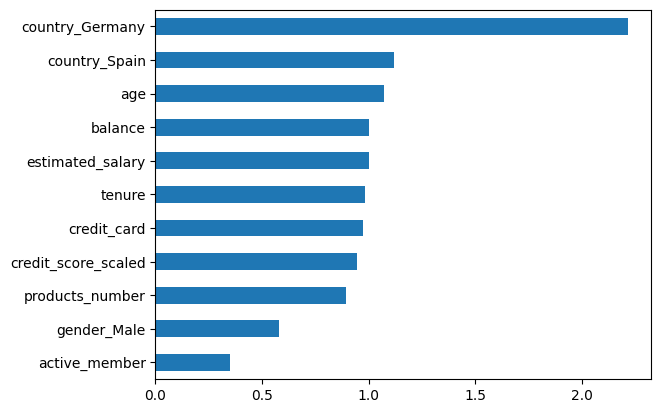

In [46]:
odds_ratios.plot(kind='barh')

In [48]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

active_member         -1.057257e+00
gender_Male           -5.487013e-01
products_number       -1.136104e-01
credit_score_scaled   -5.869926e-02
credit_card           -2.565445e-02
tenure                -1.661947e-02
estimated_salary       1.897650e-07
balance                2.458080e-06
age                    7.065880e-02
country_Spain          1.135651e-01
country_Germany        7.954158e-01
dtype: float64

LETES  EXPLORE OTHER  MODELS TO GET A BETTER MODEL PERFORMANCE

RANDOM FOREST AND GRADIENT BOOSTING

RANDOM FOREST

In [66]:
#build model
clf = make_pipeline(RandomForestClassifier(random_state=42))
print(clf)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [67]:
#setting the params
params = {
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 100, 10)
}
params

{'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 100, 10)}

In [68]:
#using gridserch to find the best params
model2 = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model2

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 100, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [69]:
model2.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 100, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [70]:
#the best model with its params
model2.best_estimator_

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, n_estimators=75,
                                        random_state=42))])

EVALUATE

train2 = model2.score(X_train, y_train)
test2 =  model2.score(X_test, y_test)

print("Training Accuracy:", round(train2, 4))
print("Test Accuracy:", round(test2, 4))

In [73]:
#cross validation scores
scores2= cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print(scores2)
print('Model2 Mean Val Score:', round(scores2.mean(), 3))

[0.86125  0.861875 0.865    0.86375  0.86125 ]
Model2 Mean Val Score: 0.863


GRADIENT BOOSTING

In [74]:
#instatiatie the model
clf2 = make_pipeline(GradientBoostingClassifier())
print(clf2)

Pipeline(steps=[('gradientboostingclassifier', GradientBoostingClassifier())])


In [75]:
#setting the parameters
params2 = {
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}
    
params2

{'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

In [76]:
#searching for the best model with the best parms for clf2
model3 = GridSearchCV(
    clf2,
    param_grid=params2,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model3

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5)},
             verbose=1)

In [77]:
model3.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5)},
             verbose=1)

EVALUATE

In [78]:
#checking the accuracy
train3 = model3.score(X_train, y_train)
test3 =  model3.score(X_test, y_test)

print("Training Accuracy:", round(train3, 4))
print("Test Accuracy:", round(test3, 4))

Training Accuracy: 0.8631
Test Accuracy: 0.8615


In [79]:
#cross validtion scores
scores3 = cross_val_score(clf2, X_train, y_train, cv=5, n_jobs=-1)
print(scores3)
print('Model3 Mean Val Score:', round(scores3.mean(), 3))

[0.871875 0.854375 0.864375 0.859375 0.858125]
Model3 Mean Val Score: 0.862


In [90]:
print(f"Model performance summary:\n"
      f"LOGISTIC REGRESSION:\n"
      f"1. Training Accuracy: {train}\n"
      f"2. Testing Accuracy: {test}\n"
      f"3. Mean Cross Val Score: {round(scores.mean(), 3)}\n"
      f"RANDOM FOREST CLASSIFIER:\n"
      f"1. Training Accuracy: {train2}\n"
      f"2. Testing Accuracy: {test2}\n"
      f"3. Mean Cross Val Score: {round(scores2.mean(), 3)}\n"
      f"GRADIENT BOOSTING CLASSIFIER:\n"
      f"1. Training Accuracy: {train3}\n"
      f"2. Testing Accuracy: {test3}\n"
      f"3. Mean Cross Val Score: {round(scores3.mean(), 3)}")

Model performance summary:
LOGISTIC REGRESSION:
1. Training Accuracy: 0.81
2. Testing Accuracy: 0.8115
3. Mean Cross Val Score: 0.81
RANDOM FOREST CLASSIFIER:
1. Training Accuracy: 0.900625
2. Testing Accuracy: 0.863
3. Mean Cross Val Score: 0.863
GRADIENT BOOSTING CLASSIFIER:
1. Training Accuracy: 0.863125
2. Testing Accuracy: 0.8615
3. Mean Cross Val Score: 0.862


ANALYSIS

- ***Logistic Regression***
  
  - Consistent performance between training, test, and cross-validation scores.
  - Performance is above baseline but significntly lower then the other two models.

- ***RandomForestClassifier***
  
   - High training accuracy indicating potential overfitting
   - Test ccuracy is lower than training accuracy but still higehr than Logistic Regression
   - Mean cross-validation score is consistent with test accurcy, suggesting reasonable generalization.

- ***GradientBoostingClassifier***
  
   - Good balance betwwen training and test accuracy, indicating less overfitting compared to RandomForest.
   - Test and mean cross-validtion scores are very close, suggesting good generalization.
   - Slightly lower training accuracy than RandomForest.

***CONCLUSION:***

GrdientBoostingClassifier appears to be the best model to use due to its balance between training and test ccuracy, indicating it generalises well to new dt.

RandomForestClassifier also performs very well but its higher training accuracy suggests it might be slightly overfitting.

Logistic Regression though consistent does not perform as well the oter two models

***Further Steps:***

There might be a need to tune the hyper parameters to potentially improve the performnce of the two ensemble models and reduce overfitting.

***I might need to reset the params for max depth of the Random Forest Clssifier from 10, 100, 10 to 10, 50, 10***